In [2]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

### astropy coorindates/units
import astropy.coordinates as coord
import astropy.constants as const
import astropy.units as u

### Gala
from gala.units import galactic
_ = coord.galactocentric_frame_defaults.set('v4.0')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable


## Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

###
import linearfitting as linfit
import geometry as geo
import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [4]:
#######################
### Import SMC Data ###
#######################

#total number 1225
smc = fits.getdata('/Users/joshpovick/Desktop/Research/SMC_Gradients/smc_rgbmembers.r13-l33-58932beta.fits.gz') 

cln = np.where((smc['FE_H']>-9999.0)&(smc['AK_TARG']>-9999.0)&(smc['LOGG']>0.0)&
               (smc['FE_H_ERR']>-90.0)&(smc['C_FE']>-9999.0)&(smc['N_FE']>-9999.0))

#total number 990
smc = smc[cln]

## Find Bloop
bloop = np.where((smc['H']<=13.25)&(smc['J']-smc['K']<=0.95)&(smc['TEFF']>=4175))
bloop_cut = []
for i in range(len(smc)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
smc_nobloop = smc[bloop_cut]

In [5]:
####################################
### Gaia Query Using Online Form ###
####################################

# (00:52:44, −72:49:42) Used in SMASH
center = SkyCoord('00:52:44 -72:49:42', unit=(u.hourangle, u.deg))

print('''Cone search center: {} with radius 6.5 deg'''.format(center))

Cone search center: <SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)> with radius 6.5 deg


In [6]:
smc_gaia = fits.getdata('smc_apogee-result.fits.gz')
cln = np.where((smc_gaia['astrometric_excess_noise']<1.0)&(np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&(np.isfinite(smc_gaia['phot_bp_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_rp_mean_mag'])==True)&(smc_gaia['parallax']<0.2)&
               (smc_gaia['parallax']>-0.2)&(smc_gaia['pmra']>=-3.0)&(smc_gaia['pmra']<=3.0)&
               (smc_gaia['pmdec']>=-3.0)&(smc_gaia['pmdec']<=3.0)&(smc_gaia['phot_g_mean_flux_over_error']>5.0)&
               (smc_gaia['phot_bp_mean_flux_over_error']>5.0)&(smc_gaia['phot_rp_mean_flux_over_error']>5.0))
smc_gaia = smc_gaia[cln]

# cuts from  

# @ARTICLE{2020MNRAS.tmp.3030O,
#        author = {{Omkumar}, Abinaya O. and {Subramanian}, Smitha and
#          {Niederhofer}, Florian and {Diaz}, Jonathan and {Cioni}, Maria-Rosa L. and
#          {El Youssoufi}, Dalal and {Bekki}, Kenji and {de Grijs}, Richard and
#          {van Loon}, Jacco Th},
#         title = "{Gaia view of a stellar sub-structure in front of the Small Magellanic Cloud}",
#       journal = {\mnras},
#      keywords = {Magellanic Clouds, galaxies: interactions, proper motions, stars: kinematics and dynamics, Astrophysics - Astrophysics of Galaxies},
#          year = 2020,
#         month = oct,
#           doi = {10.1093/mnras/staa3085},
# archivePrefix = {arXiv},
#        eprint = {2010.02687},
#  primaryClass = {astro-ph.GA},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.3030O},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

In [7]:
smc_gaia.columns

ColDefs(
    name = 'solution_id'; format = 'K'
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'
    name = 'random_index'; format = 'K'
    name = 'ref_epoch'; format = 'D'; unit = 'yr'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = 'mas'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = 'mas'
    name = 'parallax'; format = 'D'; unit = 'mas'
    name = 'parallax_error'; format = 'D'; unit = 'mas'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmra_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra_corr'; format = 'E'
    name = 'ra_pmdec_corr'; format = 'E'
    name = 'dec_parallax_corr'; format = 'E'
    na

(array([  5.,  38., 111., 175., 219., 152., 137.,  90.,  40.,  23.]),
 array([ 95.54261 , 112.231895, 128.92117 , 145.61046 , 162.29974 ,
        178.98903 , 195.67831 , 212.3676  , 229.05688 , 245.74617 ,
        262.43546 ], dtype=float32),
 <a list of 10 Patch objects>)

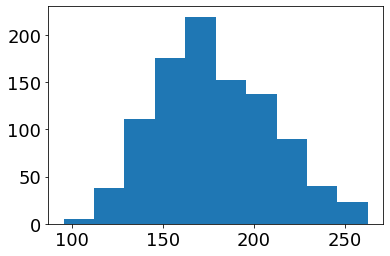

In [10]:
plt.hist(np.tan(70)*smc['VHELIO_AVG'])